# Load Packages and data

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

In [2]:
#configure figure sizes
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

First we load the dataset with MI values filled by gbm

In [4]:
tag_all = pd.read_csv("C:/Users/cos00/Desktop/Nuclear/APAN5900/Tag Data MI Filled.csv")

In [5]:
np.shape(tag_all) #dimension

(474780, 61)

In [11]:
TRAIN_SPLIT = round(np.shape(tag_all)[0]*0.8)
TRAIN_SPLIT

379824

First 379824 rows will be our training data

In [6]:
tf.random.set_seed(42)

# Time Series

## 1. Univariate

In [12]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

In [15]:
uni_data = tag_all['MI']
uni_data.head()

0    2.549957
1    2.573603
2    2.572315
3    2.444906
4    2.436210
Name: MI, dtype: float64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000179209C3CF8>],
      dtype=object)

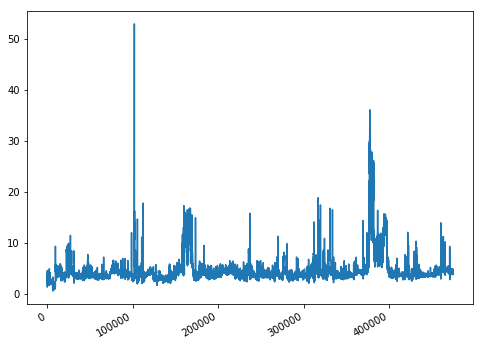

In [16]:
#observe how data moves across time
uni_data.plot(subplots=True)

In [17]:
uni_data = uni_data.values
uni_data

array([2.54995748, 2.57360314, 2.572315  , ..., 4.07600911, 4.22180419,
       4.22838158])

Normalize data

In [19]:
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()
uni_data = (uni_data-uni_train_mean)/uni_train_std

Create data for univariant model

In [85]:
univariate_past_history = 60
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

In [86]:
def create_time_steps(length):
  time_steps = []
  for i in range(-length, 0, 1):
    time_steps.append(i)
  return time_steps

In [87]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

<module 'matplotlib.pyplot' from 'D:\\Anacoda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

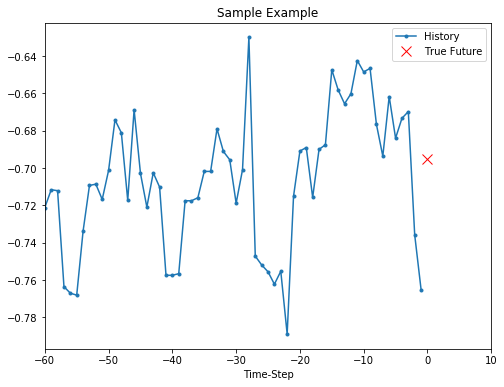

In [88]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

### Baseline

In [24]:
def baseline(history):
  return np.mean(history)

<module 'matplotlib.pyplot' from 'D:\\Anacoda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

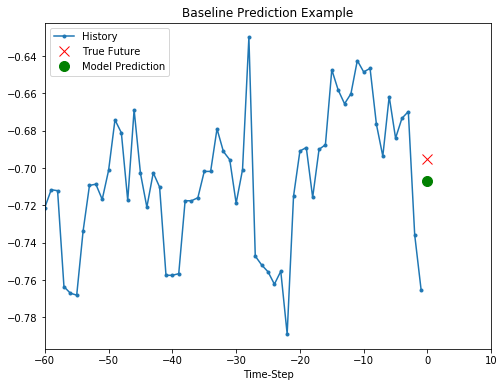

In [93]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
           'Baseline Prediction Example')

### RNN

In [89]:
#Long short term memory of RNN
BATCH_SIZE = 60
BUFFER_SIZE = 100

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [90]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(12, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

In [91]:
#sample prediction
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

(60, 1)


Train the model

In [92]:
EVALUATION_INTERVAL = 1000
EPOCHS = 10

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=100)

Train for 1000 steps, validate for 100 steps
Epoch 1/10
1000/1000 [==============================] - 32s 32ms/step - loss: 0.0993 - val_loss: 2.0651
Epoch 2/10
1000/1000 [==============================] - 30s 30ms/step - loss: 0.0472 - val_loss: 1.5011
Epoch 3/10
1000/1000 [==============================] - 30s 30ms/step - loss: 0.0618 - val_loss: 1.1504
Epoch 4/10
1000/1000 [==============================] - 28s 28ms/step - loss: 0.0439 - val_loss: 1.0899
Epoch 5/10
1000/1000 [==============================] - 28s 28ms/step - loss: 0.0313 - val_loss: 1.0672
Epoch 6/10
1000/1000 [==============================] - 30s 30ms/step - loss: 0.0355 - val_loss: 1.0633
Epoch 7/10
1000/1000 [==============================] - 30s 30ms/step - loss: 0.1116 - val_loss: 0.3094
Epoch 8/10
1000/1000 [==============================] - 31s 31ms/step - loss: 0.0238 - val_loss: 0.3115
Epoch 9/10
1000/1000 [==============================] - 32s 32ms/step - loss: 0.0381 - val_loss: 0.5151
Epoch 10/10
1000/10

predict the model

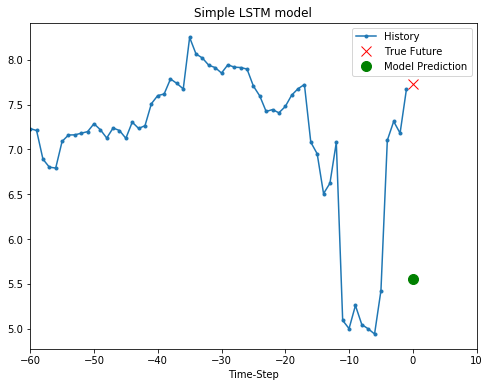

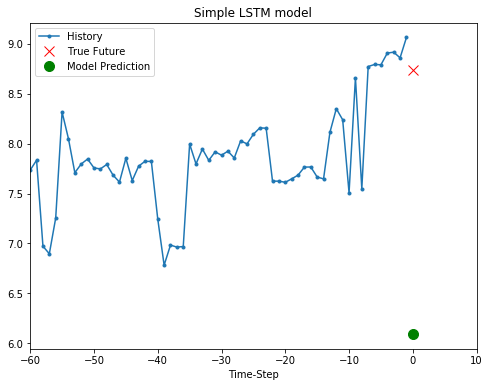

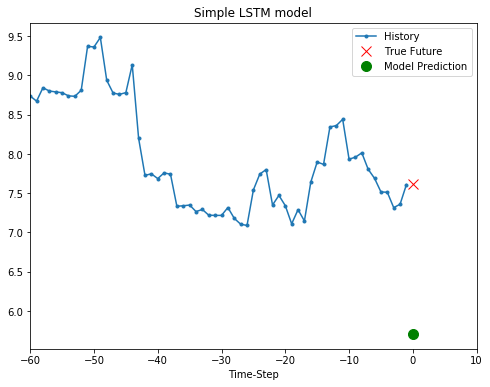

In [94]:
for x, y in val_univariate.take(3):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
  plot.show()

In [95]:
error_uni = list()
print("Example of first 3")
for x, y in val_univariate.take(5):
    yact = uni_train_mean + uni_train_std * y[0].numpy()
    ypred = uni_train_mean + uni_train_std * simple_lstm_model.predict(x)[0]
    print("Actual: " + str(yact))
    print("Predicted: " + str(ypred))
    error_val = ypred-yact
    print("Error: " + str(error_val))
    
for x, y in val_univariate.take(100):
    yact = uni_train_mean + uni_train_std * y[0].numpy()
    ypred = uni_train_mean + uni_train_std * simple_lstm_model.predict(x)[0]
    error_val = ypred-yact
    error_uni.append(error_val)

Example of first 3
Actual: 23.49366772805506
Predicted: [18.085403]
Error: [-5.408264]
Actual: 25.97817204838725
Predicted: [19.424953]
Error: [-6.553219]
Actual: 23.200705095485525
Predicted: [18.472645]
Error: [-4.72806]
Actual: 25.416366267414894
Predicted: [19.27066]
Error: [-6.145706]
Actual: 24.16358170765833
Predicted: [18.729628]
Error: [-5.4339542]


In [96]:
def rmse(list):
    squares = [i ** 2 for i in list]
    rmse = np.sqrt(np.array(squares).mean())
    return rmse

In [97]:
rmse(error_uni)

2.8632782

## 2. Multivariate

get top 10 features with highest linear correlation with MI according to headmap. Check Data Exploration script for details

In [100]:

feature_considered = ['P1:FC70113','P1:FC70310','P1:FFC70106','P1:FR70106','P1:QIA701001', 'P1:PR70200', 'P1:R700RECYCLEB', 
                     'P1:TI70141', 'P1:TI70304','P1:TR70104','P1:TR70201','P1:TR70305'] 

features = tag_all[feature_considered]

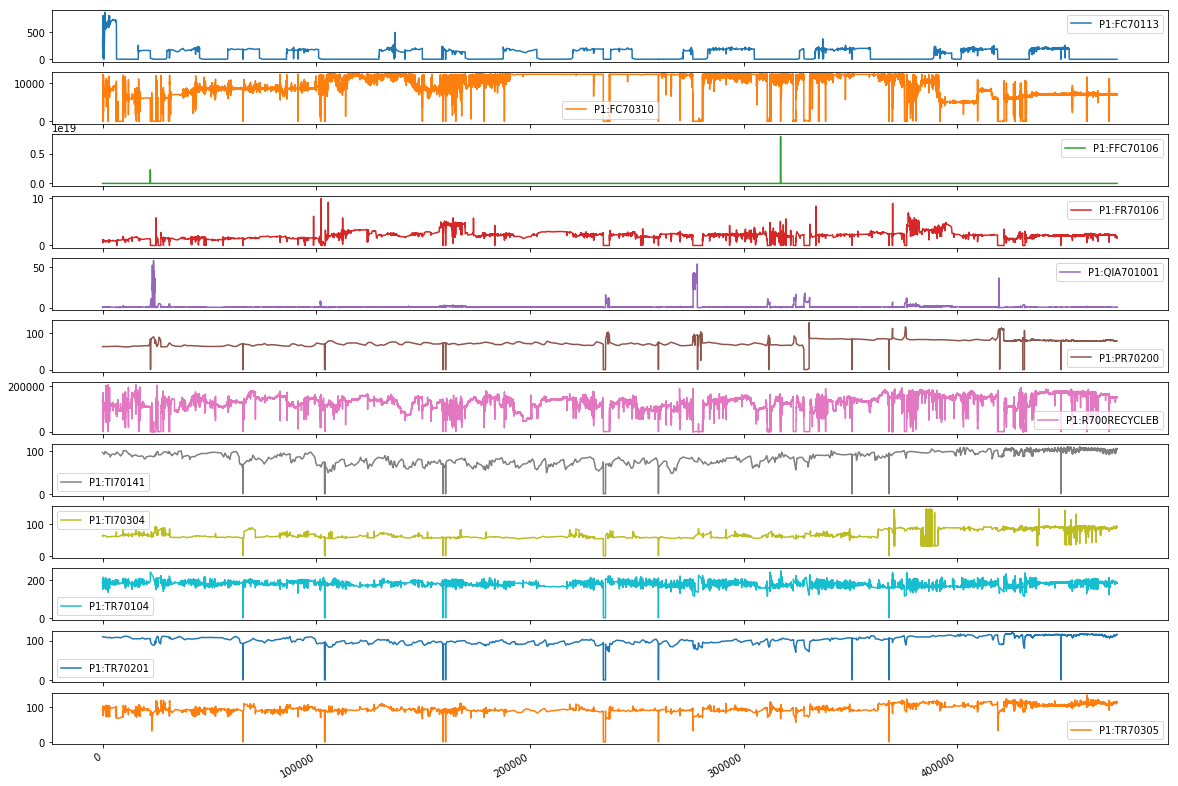

In [101]:
features.plot(subplots=True)
fig=plt.gcf()
fig.set_size_inches(20,15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

Normalize the data

In [57]:

dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

In [58]:
dataset = (dataset-data_mean)/data_std

### Single step model

In [59]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [102]:
past_history = 60
future_target = 1
STEP = 1
mi_index = 0

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, mi_index], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, mi_index],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

In [103]:
x_val_single.shape

(94895, 60, 10)

In [104]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [124]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(24, input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

In [106]:
for x, y in val_data_single.take(1):
  print(single_step_model.predict(x).shape)

(60, 1)


train model

In [107]:
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=100)

Train for 1000 steps, validate for 100 steps
Epoch 1/10
1000/1000 [==============================] - 55s 55ms/step - loss: 0.2121 - val_loss: 0.2248
Epoch 2/10
1000/1000 [==============================] - 52s 52ms/step - loss: 0.0362 - val_loss: 0.0568
Epoch 3/10
1000/1000 [==============================] - 54s 54ms/step - loss: 0.0291 - val_loss: 0.1008
Epoch 4/10
1000/1000 [==============================] - 53s 53ms/step - loss: 0.0266 - val_loss: 0.1332
Epoch 5/10
1000/1000 [==============================] - 54s 54ms/step - loss: 0.0261 - val_loss: 0.1092
Epoch 6/10
1000/1000 [==============================] - 63s 63ms/step - loss: 0.0297 - val_loss: 0.0938
Epoch 7/10
1000/1000 [==============================] - 72s 72ms/step - loss: 0.0403 - val_loss: 0.0918
Epoch 8/10
1000/1000 [==============================] - 74s 74ms/step - loss: 0.0290 - val_loss: 0.0450
Epoch 9/10
1000/1000 [==============================] - 72s 72ms/step - loss: 0.0247 - val_loss: 0.0745
Epoch 10/10
1000/10

In [66]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

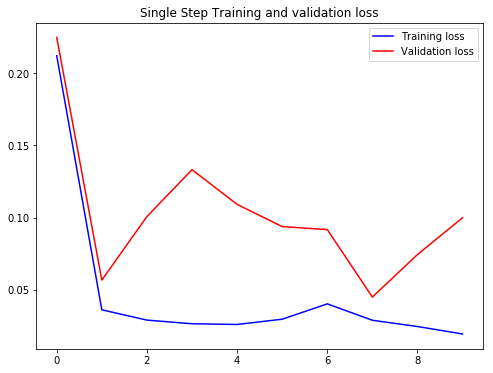

In [108]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

predict

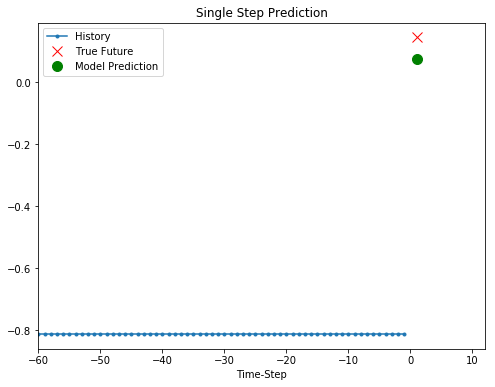

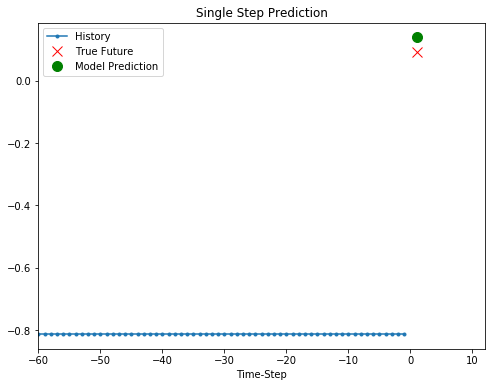

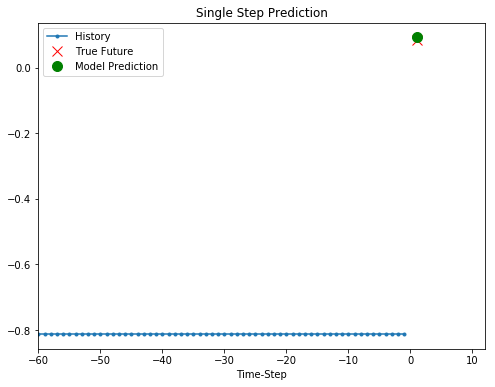

In [109]:
for x, y in val_data_single.take(3):
  plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], STEP,
                   'Single Step Prediction')
  plot.show()

In [110]:
error_single = list()
print("Example of first 3")
for x, y in val_data_single.take(3):
    yact = uni_train_mean + uni_train_std * y[0].numpy()
    ypred = uni_train_mean + uni_train_std * single_step_model.predict(x)[0]
    print("Actual: " + str(yact))
    print("Predicted: " + str(ypred))
    error_val = ypred-yact
    print("Error: " + str(error_val))
    
for x, y in val_data_single.take(100):
    yact = uni_train_mean + uni_train_std * y[0].numpy()
    ypred = uni_train_mean + uni_train_std * single_step_model.predict(x)[0]
    error_val = ypred-yact
    error_single.append(error_val)

Example of first 3
Actual: 4.692743453212872
Predicted: [4.5224485]
Error: [-0.17029476]
Actual: 4.566736370368019
Predicted: [4.6793942]
Error: [0.11265802]
Actual: 4.547905496548987
Predicted: [4.564365]
Error: [0.01645947]


In [111]:
rmse(error_single)

0.29167467

### Multiple step model

In [112]:
future_target = 10
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, mi_index], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, mi_index],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

In [113]:
x_train_multi.shape

(379764, 60, 10)

In [114]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [76]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

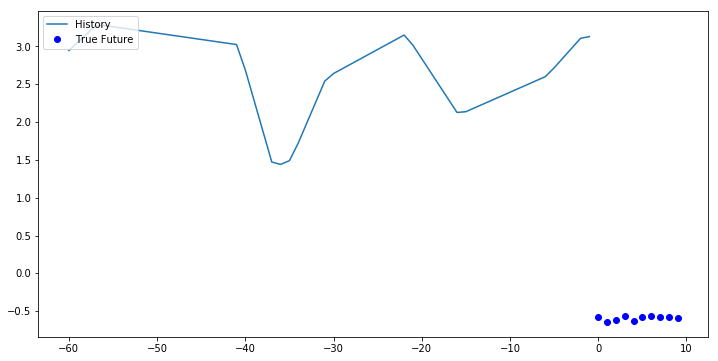

In [115]:
for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

In [125]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(24,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(future_target))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

In [126]:
for x, y in val_data_multi.take(1):
  print (multi_step_model.predict(x).shape)

(60, 10)


predict

In [127]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=100)

Train for 1000 steps, validate for 100 steps
Epoch 1/10
1000/1000 [==============================] - 313s 313ms/step - loss: 0.4157 - val_loss: 0.2009
Epoch 2/10
1000/1000 [==============================] - 329s 329ms/step - loss: 0.0616 - val_loss: 0.1306
Epoch 3/10
1000/1000 [==============================] - 318s 318ms/step - loss: 0.0422 - val_loss: 0.1515
Epoch 4/10
1000/1000 [==============================] - 306s 306ms/step - loss: 0.0589 - val_loss: 0.1406
Epoch 5/10
1000/1000 [==============================] - 310s 310ms/step - loss: 0.0463 - val_loss: 65.6268
Epoch 6/10
1000/1000 [==============================] - 316s 316ms/step - loss: 0.0539 - val_loss: 0.1443
Epoch 7/10
1000/1000 [==============================] - 368s 368ms/step - loss: 0.1388 - val_loss: 0.1409
Epoch 8/10
1000/1000 [==============================] - 349s 349ms/step - loss: 0.2552 - val_loss: 0.1140
Epoch 9/10
1000/1000 [==============================] - 336s 336ms/step - loss: 0.0356 - val_loss: 0.1293


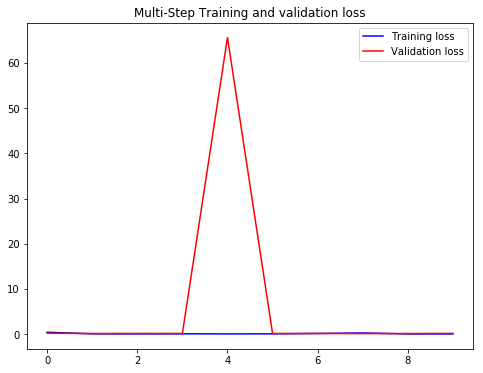

In [128]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

predict

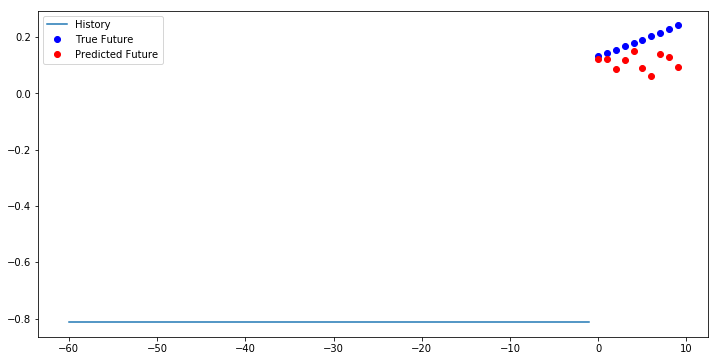

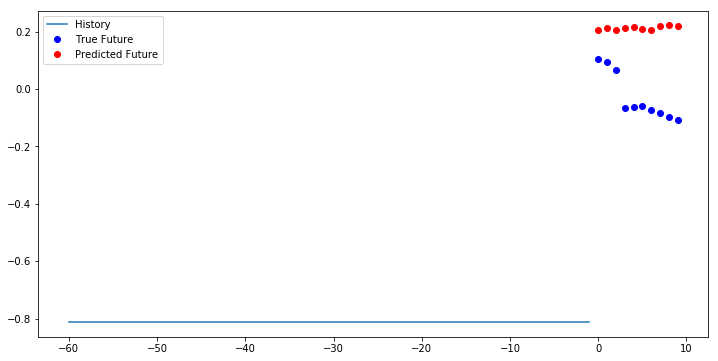

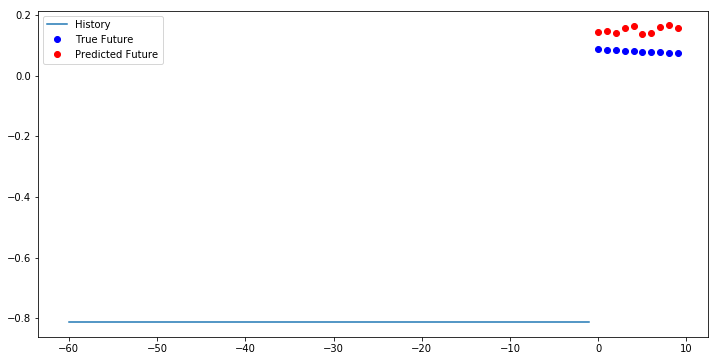

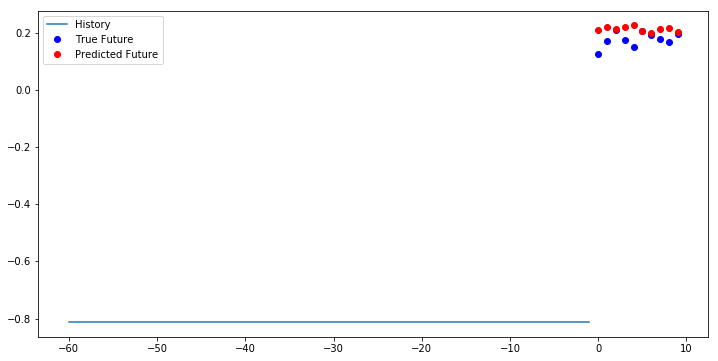

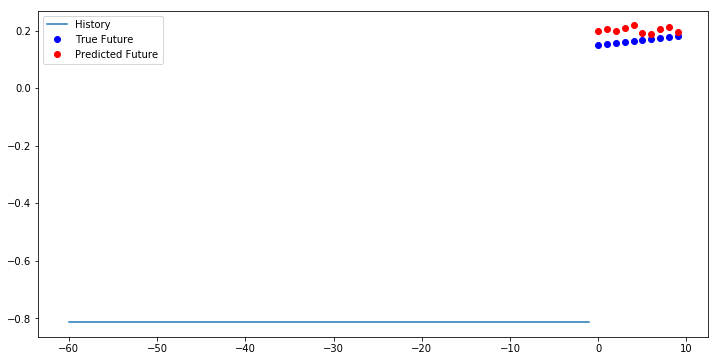

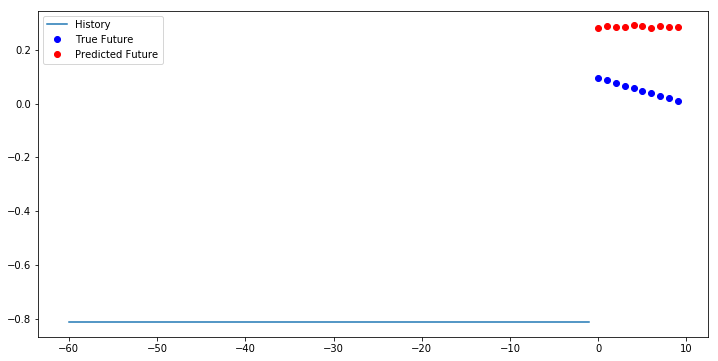

In [129]:
for x, y in val_data_multi.take(6):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])

In [130]:
error_multi = list()
print("Example of first 3")
for x, y in val_data_multi.take(3):
    yact = uni_train_mean + uni_train_std * y[0].numpy()
    ypred = uni_train_mean + uni_train_std * multi_step_model.predict(x)[0][0]
    print("Actual: " + str(yact))
    print("Predicted: " + str(ypred))
    error_val = ypred-yact
    print("Error: " + str(error_val))

Example of first 3
Actual: [4.66373628 4.69274345 4.72175086 4.75075803 4.77976637 4.80902763
 4.84054817 4.87206777 4.90358807 4.93510768]
Predicted: 4.6380136946798896
Error: [-0.02572259 -0.05472976 -0.08373716 -0.11274434 -0.14175268 -0.17101394
 -0.20253447 -0.23405408 -0.26557438 -0.29709398]
Actual: [4.59813476 4.56673637 4.50194513 4.1732037  4.18315272 4.18912423
 4.15914826 4.12917299 4.09919679 4.06922059]
Predicted: 4.844822435206583
Error: [0.24668768 0.27808606 0.34287731 0.67161874 0.66166972 0.65569821
 0.68567418 0.71564944 0.74562564 0.77560184]
Actual: [4.55152239 4.5479055  4.5442879  4.54067008 4.53705342 4.53343559
 4.529818   4.52620111 4.52258328 4.51896569]
Predicted: 4.6957287952327995
Error: [0.14420641 0.1478233  0.15144089 0.15505872 0.15867538 0.1622932
 0.16591079 0.16952769 0.17314551 0.1767631 ]


In [131]:
for i in range(6):
    error_multi = list()
    for x, y in val_data_multi.take(100):
        yact = uni_train_mean + uni_train_std * y[0].numpy()
        ypred = uni_train_mean + uni_train_std * multi_step_model.predict(x)[0][i]
        error_val = ypred-yact
        error_multi.append(error_val)
    print("RMSE t+"+ str(i+1) +": " + str(rmse(error_multi)))

RMSE t+1: 0.5595297540043872
RMSE t+2: 0.5322264199738911
RMSE t+3: 0.5414385742322548
RMSE t+4: 0.5239711475315691
RMSE t+5: 0.5054044132578763
RMSE t+6: 0.5454343640749773
